In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tifffile
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from transformers import SamModel
from pathlib import Path
from monai.metrics import compute_iou, DiceHelper
from micro_sam.util import get_sam_model, get_device
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
import os

data_path = Path('data').absolute()


2024-04-30 00:05:19.940795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 00:05:25.129975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Utility functions

In [3]:
def read_dir(path):
    '''read files from local file system on the path'''
    for file_name in os.listdir(str(path)):
        if file_name.endswith(".tif"):
            image = tifffile.imread(str(path.joinpath(file_name)))
            yield file_name, image


def get_dataloader(patch_shape, batch_size, train_instance_segmentation, image_dir, segmentation_dir):
    # This will download the image and segmentation data for training.
    #image_dir = str(data_path.joinpath('image_tif'))
    #segmentation_dir = str(data_path.joinpath('instance_labeling'))

    raw_key, label_key = "*.tif", "*.tif"

    roi = np.s_[:, :, :]
    if train_instance_segmentation:
        # Computes the distance transform for objects to perform end-to-end automatic instance segmentation.
        label_transform = PerObjectDistanceTransform(
            distances=True, boundary_distances=True, directed_distances=False,
            foreground=True, instances=True, min_size=25
        )
    else:
        label_transform = torch_em.transform.label.connected_components

    loader = torch_em.default_segmentation_loader(
        raw_paths=image_dir, raw_key=raw_key,
        label_paths=segmentation_dir, label_key=label_key,
        patch_shape=patch_shape, batch_size=batch_size,
        ndim=2, is_seg_dataset=True, rois=roi,
        label_transform=label_transform,
        num_workers=2, shuffle=True, raw_transform=sam_training.identity,
    )
    return loader


rng = np.random.default_rng()


def get_bounding_box(mask):
    # get bounding box from mask, get minimum and maximum x and y
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    bbox = [x_min, y_min, x_max, y_max]
    return bbox


def get_instance_masks(image):  # used for input while training
    myelin_mask = image == 1
    myelin_instances, num_instances = ndimage.label(myelin_mask)
    axon_mask = image == 2
    axon_instances, _ = ndimage.label(axon_mask)
    axon_instances[axon_instances > 0] += num_instances
    return myelin_instances + axon_instances, num_instances


def get_boxes_points(image):
    '''find bounding box and point prompt for each instance of axon or myelin when evaluating'''
    axon_boxes = []
    axon_centroids = []
    myelin_points = []  # pick random point on myelin

    axons = image == 2
    labled_array, num_instances = ndimage.label(axons)
    for i in range(1, num_instances + 1):  # 0 is background
        instance_binary_mask = labled_array == i
        center = ndimage.center_of_mass(instance_binary_mask)
        axon_centroids.append([center[1], center[0]])
        axon_boxes.append(get_bounding_box(instance_binary_mask))

    myelin = image == 1
    labeled_array, num_instances = ndimage.label(myelin)
    for i in range(1, num_instances + 1):
        instance_binary_mask = labeled_array == i
        myelin_points.append(rng.choice(np.argwhere(instance_binary_mask)))

    return axon_boxes, axon_centroids, myelin_points



### Evaluation

The following section is designed to be ran after the model has finished training

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, ax, marker_size=5):
    ax.scatter([coord[1] for coord in coords], [coord[0] for coord in coords], color='green', marker='*', s=marker_size,
               edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def show_anns(anns, ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

Plot results of example test images

In [11]:
def plot_image_result(file_name):
    image = tifffile.imread(str(data_path.joinpath("val", "image_tif", file_name)))
    mask = tifffile.imread(str(data_path.joinpath("val", "mask_tif", file_name)))
    fig, axes = plt.subplots(2, 3, figsize=(10, 10))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original image')

    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Ground truth mask')

    rgb_image = Image.fromarray(image).convert('RGB')
    predictor.set_image(np.array(rgb_image))
    axon_boxes, axon_centroids, myelin_points = get_boxes_points(mask)

    axes[0, 2].imshow(image, cmap='gray')
    axes[0, 2].set_title('SAM Prediction with axon point prompts')
    # show_points(all_points, axes[0,2])
    masks = []
    for centroid in axon_centroids:
        mask, scores, logits = predictor.predict(
            point_coords=np.array([centroid]),
            point_labels=np.array([1]),
            multimask_output=False,
        )
        masks.append(mask)
    for mask in masks:
        show_mask(mask, axes[0, 2], random_color=True)

    axes[1, 0].imshow(image, cmap='gray')
    axes[1, 0].set_title('SAM Prediction with axon box prompts')
    masks = []
    for box in axon_boxes:
        mask, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=np.array(box)[None, :],
            multimask_output=False,
        )
        masks.append(mask)
    for mask in masks:
        show_mask(mask, axes[1, 0], random_color=True)

    axes[1, 1].imshow(image, cmap='gray')
    axes[1, 1].set_title('SAM Prediction with axon+myelin point prompts')
    masks = []
    for centroid in axon_centroids:
        mask, scores, logits = predictor.predict(
            point_coords=np.array([centroid]),
            point_labels=np.array([1]),
            multimask_output=False,
        )
        masks.append(mask)
    for point in myelin_points:
        mask, scores, logits = predictor.predict(
            point_coords=np.array([point]),
            point_labels=np.array([2]),
            multimask_output=False,
        )
        masks.append(mask)
    for mask in masks:
        show_mask(mask, axes[1, 1], random_color=True)

    axes[1, 2].imshow(image, cmap='gray')
    axes[1, 2].set_title('SAM Prediction with equidistant point prompts')
    masks = mask_generator.generate(np.array(rgb_image))
    show_anns(masks, axes[1, 2])

    plt.show()

Calculate average IOU per instance of axon or myelin

In [15]:
def evaluate_iou(predictor, mask_path):
    ious = []
    ious_axon = []
    ious_myelin = []
    ious_at_large = []
    for file_name, image in tqdm(read_dir(data_path.joinpath("val", "image_tif"))):
        gt_mask = tifffile.imread(str(mask_path.joinpath(file_name)))
        axon_boxes, axon_centroids, myelin_points = get_boxes_points(gt_mask)
        instance_gt_mask, num_instance_myelins = get_instance_masks(gt_mask)
        all_masks = np.zeros(gt_mask.shape)
        rgb_image = Image.fromarray(image).convert('RGB')
        predictor.set_image(np.array(rgb_image))
        for index, point in enumerate(myelin_points + axon_centroids):
            current_instance_mask = instance_gt_mask == instance_gt_mask[int(point[1]), int(point[0])]
            mask, _, _ = predictor.predict(
                point_coords=np.array([point]),
                point_labels=np.array([1]),
                multimask_output=False
            )
            all_masks += mask.squeeze(0)
            iou_score = compute_iou(torch.tensor(mask).squeeze(0), torch.tensor(current_instance_mask))
            ious.append(iou_score)
            if index < num_instance_myelins:
                ious_myelin.append(iou_score)
            else:
                ious_axon.append(iou_score)
        ious_at_large.append(compute_iou(torch.tensor(all_masks > 0), torch.tensor(gt_mask > 0)))

    print(
        f"The overall average IOU score over all instances of all images of the current model is {np.average(np.stack(ious))}"
    )
    print(
        f"The overall average IOU score over axon instances of all images of the current model is {np.average(np.stack(ious_axon))}"
    )
    print(
        f"The overall average IOU score over myelin instances of all images of the current model is {np.average(np.stack(ious_myelin))}"
    )
    print(
        f"The overall average IOU score at large of the current model is {np.average(np.stack(ious_at_large))}"
    )

### Combined mask Finetuned model

In [12]:
model_type = "vit_b_lm"
device = "cuda"

device = get_device(device)
_, model = get_sam_model(
    model_type=model_type, device=device, checkpoint_path="finetuned_hela_model_orig.pth", return_sam=True
)

predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)


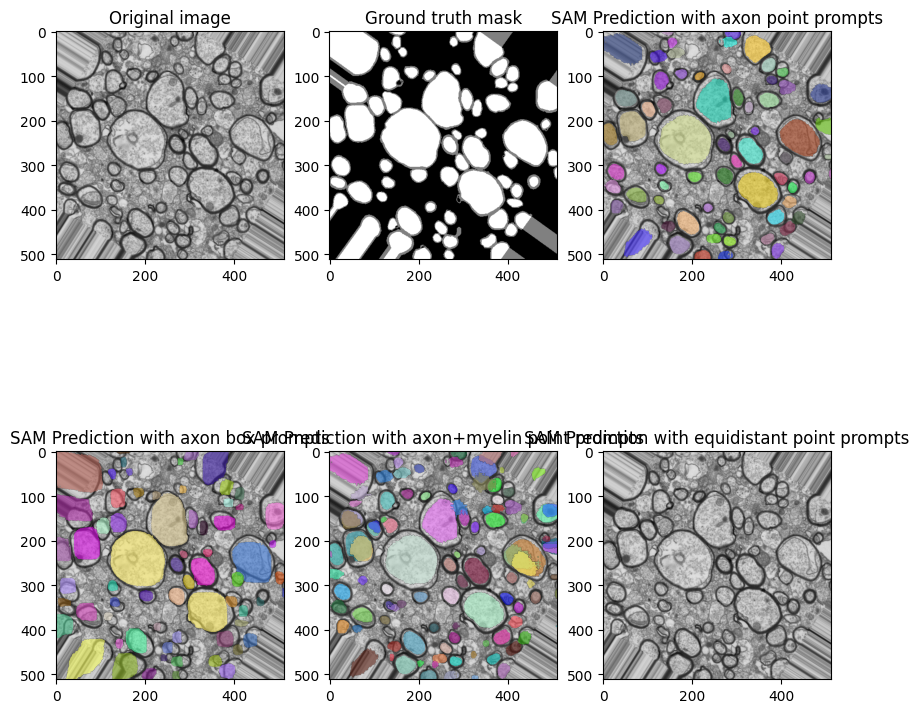

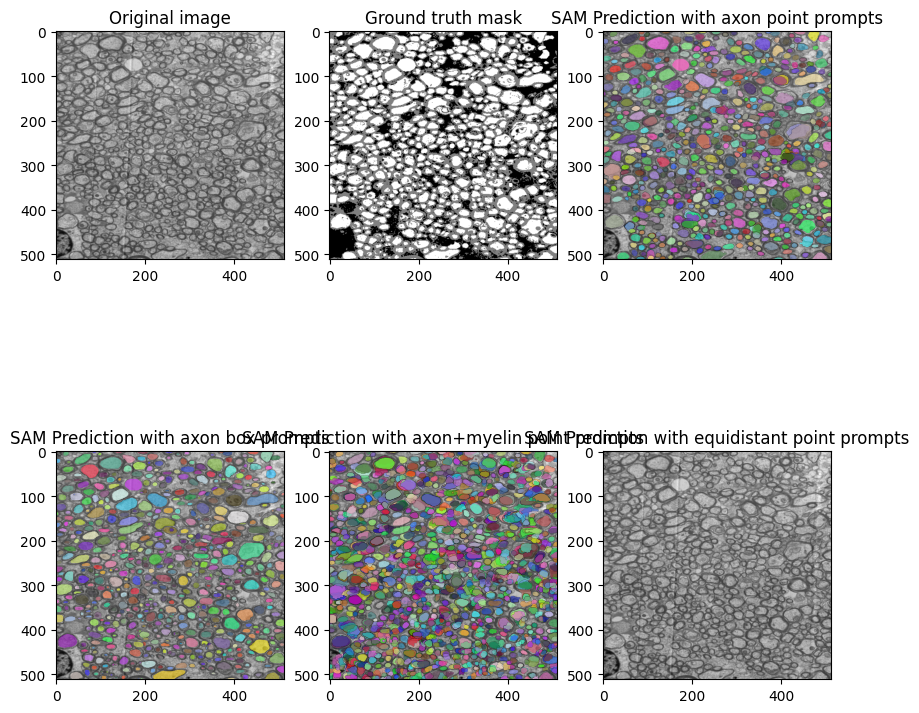

In [13]:
plot_image_result("7_EM1_3_10D_N_P_0002_1.tif")
plot_image_result("01_3.tif")

In [16]:
evaluate_iou(predictor, data_path.joinpath("val", "mask_tif"))

23it [05:00, 13.05s/it]


The overall average IOU score over all instances of all images of the current model is 0.1467158943414688
The overall average IOU score over axon instances of all images of the current model is 0.2386409491300583
The overall average IOU score over myelin instances of all images of the current model is 0.10693886876106262
The overall average IOU score at large of the current model is 0.5513154864311218


### Baseline: vit_b_lm

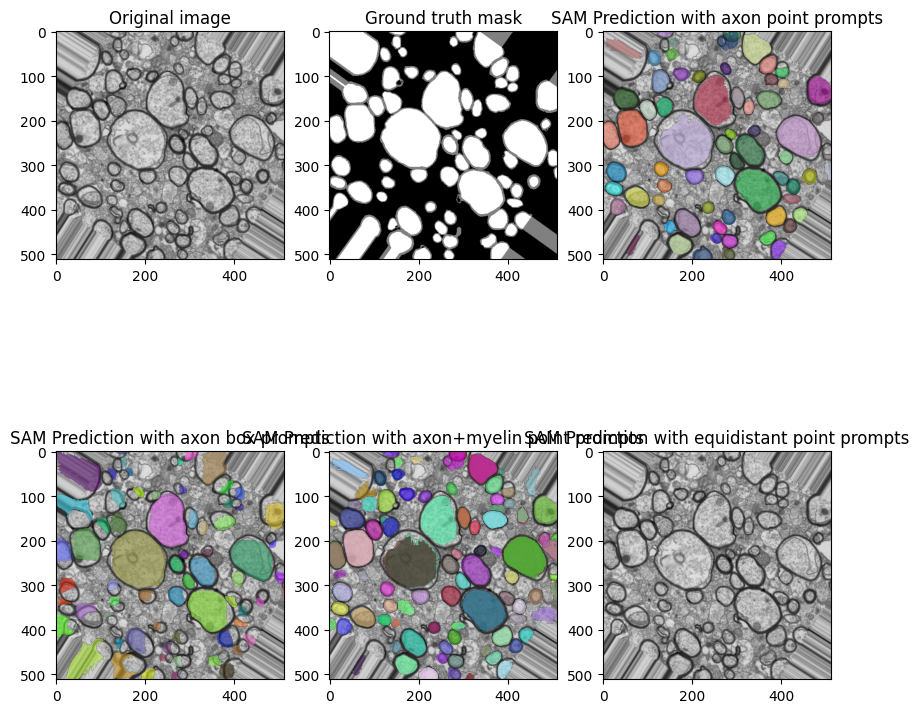

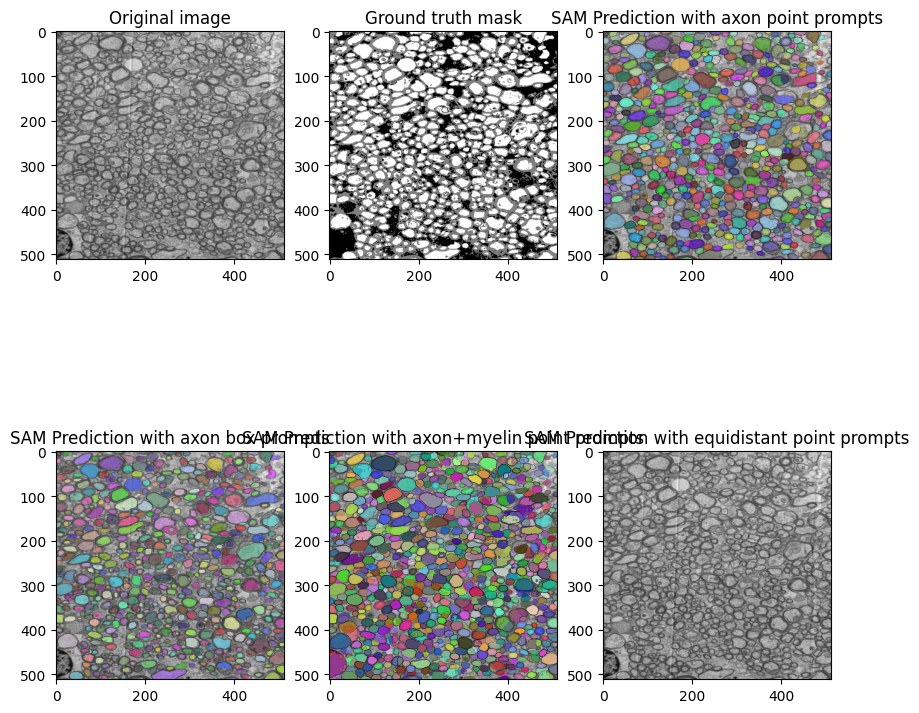

In [8]:
device = get_device('cuda')
_, model = get_sam_model(
    model_type="vit_b_lm", device=device, return_sam=True
)

predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)

plot_image_result("7_EM1_3_10D_N_P_0002_1.tif")
plot_image_result("01_3.tif")

In [9]:
evaluate_iou(predictor, data_path.joinpath("val", "mask_tif"))

23it [05:32, 14.45s/it]


The overall average IOU score over all instances of all images of the current model is 0.12326474487781525
The overall average IOU score over axon instances of all images of the current model is 0.18804877996444702
The overall average IOU score over myelin instances of all images of the current model is 0.09523196518421173
The overall average IOU score at large of the current model is 0.5689006447792053


### Instance mask

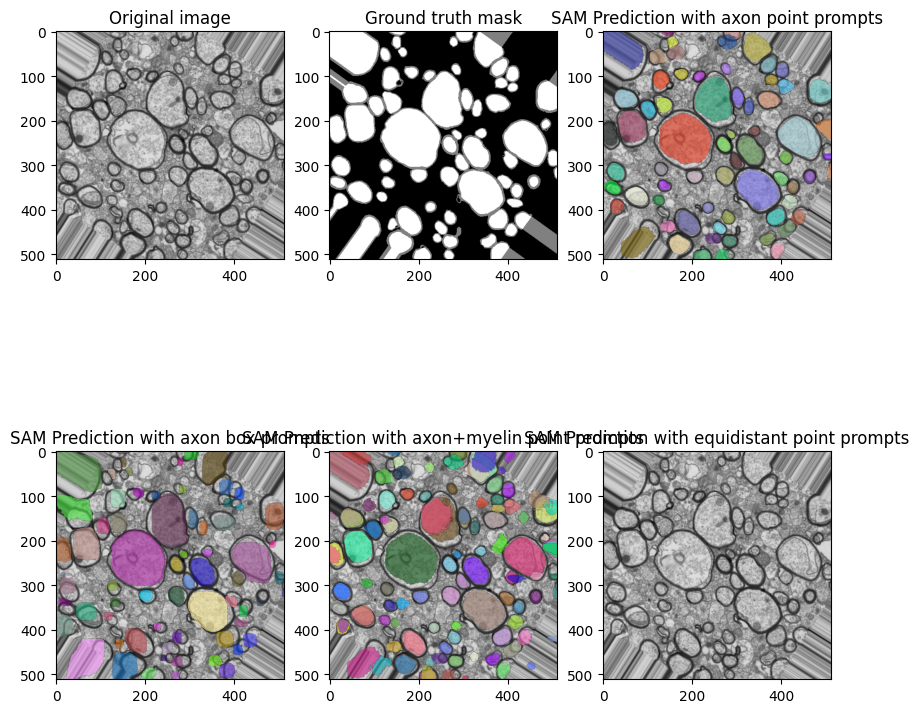

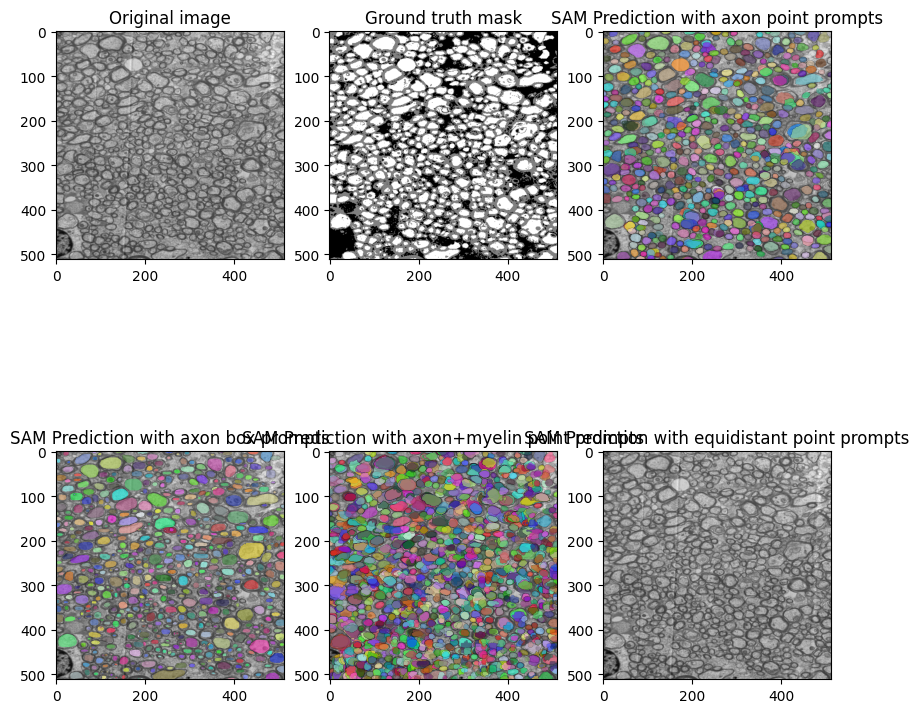

In [17]:
model_type = "vit_b_lm"
device = "cuda"

device = get_device(device)
_, model = get_sam_model(
    model_type=model_type, device=device, checkpoint_path="finetuned_hela_model_ins.pth", return_sam=True
)

predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)

plot_image_result("7_EM1_3_10D_N_P_0002_1.tif")
plot_image_result("01_3.tif")

In [18]:
evaluate_iou(predictor, data_path.joinpath("val", "mask_tif"))

23it [05:04, 13.22s/it]


The overall average IOU score over all instances of all images of the current model is 0.1398392617702484
The overall average IOU score over axon instances of all images of the current model is 0.21886387467384338
The overall average IOU score over myelin instances of all images of the current model is 0.10564442723989487
The overall average IOU score at large of the current model is 0.5785797238349915


### Class mask 

In [19]:
device = get_device('cuda')
_, axon_model = get_sam_model(
    model_type="vit_b_lm", device=device, checkpoint_path="finetuned_hela_model_axon.pth", return_sam=True
)
_, myelin_model = get_sam_model(
    model_type="vit_b_lm", device=device, checkpoint_path="finetuned_hela_model_myelin.pth", return_sam=True
)
axon_predictor = SamPredictor(axon_model)
myelin_predictor = SamPredictor(myelin_model)
axon_mask_generator = SamAutomaticMaskGenerator(axon_model)
myelin_mask_generator = SamAutomaticMaskGenerator(myelin_model)


In [6]:
def plot_image_result_sep(file_name):
    image = tifffile.imread(str(data_path.joinpath("val", "image_tif", file_name)))
    mask = tifffile.imread(str(data_path.joinpath("val", "mask_tif", file_name)))
    fig, axes = plt.subplots(2, 3, figsize=(10, 10))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original image')

    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Ground truth mask')

    rgb_image = Image.fromarray(image).convert('RGB')
    axon_predictor.set_image(np.array(rgb_image))
    myelin_predictor.set_image(np.array(rgb_image))
    axon_boxes, axon_centroids, myelin_points = get_boxes_points(mask)

    axes[0, 2].imshow(image, cmap='gray')
    axes[0, 2].set_title('SAM Prediction with axon point prompts')
    # show_points(all_points, axes[0,2])
    masks = []
    for centroid in axon_centroids:
        mask, scores, logits = axon_predictor.predict(
            point_coords=np.array([centroid]),
            point_labels=np.array([1]),
            multimask_output=False,
        )
        masks.append(mask)
    for mask in masks:
        show_mask(mask, axes[0, 2], random_color=True)

    axes[1, 0].imshow(image, cmap='gray')
    axes[1, 0].set_title('SAM Prediction with axon box prompts')
    masks = []
    for box in axon_boxes:
        mask, scores, logits = axon_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=np.array(box)[None, :],
            multimask_output=False,
        )
        masks.append(mask)
    for mask in masks:
        show_mask(mask, axes[1, 0], random_color=True)

    axes[1, 1].imshow(image, cmap='gray')
    axes[1, 1].set_title('SAM Prediction with myelin point prompts')
    masks = []
    for point in myelin_points:
        mask, scores, logits = myelin_predictor.predict(
            point_coords=np.array([point]),
            point_labels=np.array([2]),
            multimask_output=False,
        )
        masks.append(mask)
    for mask in masks:
        show_mask(mask, axes[1, 1], random_color=True)

    axes[1, 2].imshow(image, cmap='gray')
    axes[1, 2].set_title('SAM Prediction with equidistant point prompts')
    masks = axon_mask_generator.generate(np.array(rgb_image))
    show_anns(masks, axes[1, 2])
    masks = myelin_mask_generator.generate(np.array(rgb_image))
    show_anns(masks, axes[1, 2])

    plt.show()

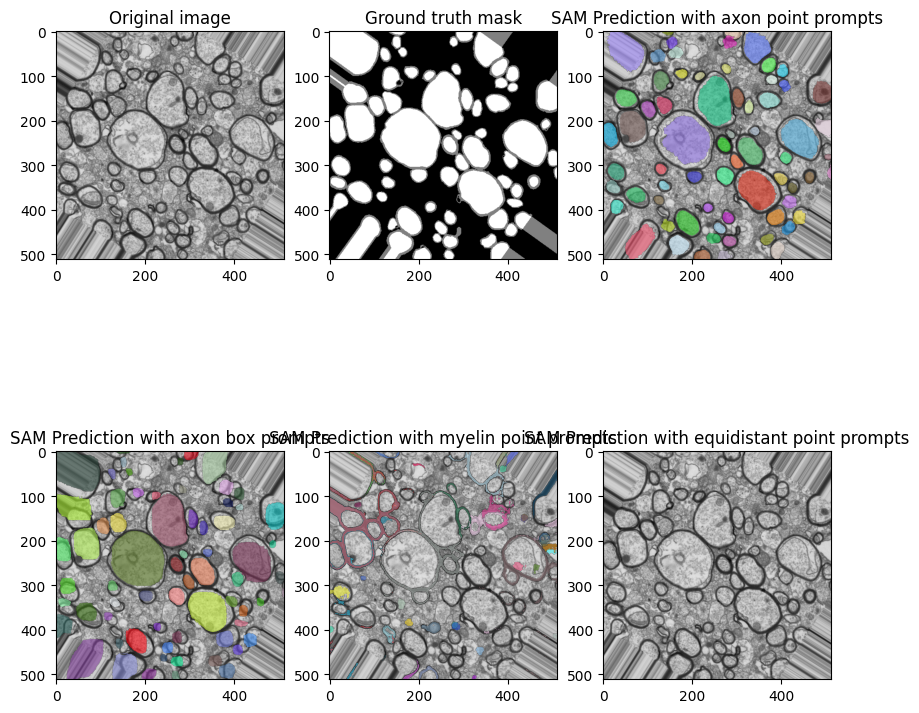

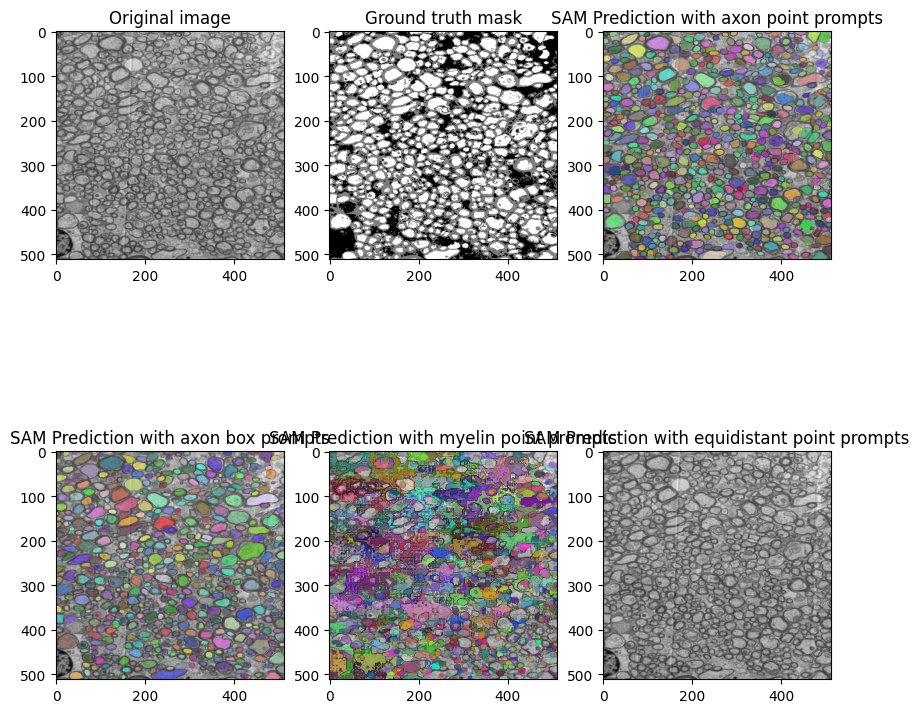

In [7]:
plot_image_result_sep("7_EM1_3_10D_N_P_0002_1.tif")
plot_image_result_sep("01_3.tif")

In [14]:
ious = []
ious_axon = []
ious_myelin = []
ious_at_large = []
for file_name, image in tqdm(read_dir(data_path.joinpath("val", "image_tif"))):
    gt_mask = tifffile.imread(str(data_path.joinpath("val", "mask_tif", file_name)))
    axon_boxes, axon_centroids, myelin_points = get_boxes_points(gt_mask)
    instance_gt_mask, num_instance_myelins = get_instance_masks(gt_mask)
    all_masks = np.zeros(gt_mask.shape)
    rgb_image = Image.fromarray(image).convert('RGB')
    axon_predictor.set_image(np.array(rgb_image))
    myelin_predictor.set_image(np.array(rgb_image))
    for index, point in enumerate(myelin_points + axon_centroids):
        current_instance_mask = instance_gt_mask == instance_gt_mask[int(point[1]), int(point[0])]
        predictor = myelin_predictor if index < num_instance_myelins else axon_predictor
        mask, _, _ = predictor.predict(
            point_coords=np.array([point]),
            point_labels=np.array([1]),
            multimask_output=False
        )
        all_masks += mask.squeeze(0)
        iou_score = compute_iou(torch.tensor(mask).squeeze(0), torch.tensor(current_instance_mask))
        ious.append(iou_score)
        if index < num_instance_myelins:
            ious_myelin.append(iou_score)
        else:
            ious_axon.append(iou_score)
    ious_at_large.append(compute_iou(torch.tensor(all_masks > 0), torch.tensor(gt_mask > 0)))

print(
    f"The overall average IOU score over all instances of all images of the current model is {np.average(np.stack(ious))}"
)
print(
    f"The overall average IOU score over axon instances of all images of the current model is {np.average(np.stack(ious_axon))}"
)
print(
    f"The overall average IOU score over myelin instances of all images of the current model is {np.average(np.stack(ious_myelin))}"
)
print(
    f"The overall average IOU score at large of the current model is {np.average(np.stack(ious_at_large))}"
)

23it [05:48, 15.16s/it]


The overall average IOU score over all instances of all images of the current model is 0.14024491608142853
The overall average IOU score over axon instances of all images of the current model is 0.2653697431087494
The overall average IOU score over myelin instances of all images of the current model is 0.08610197901725769
The overall average IOU score at large of the current model is 0.5925522446632385


Due to the lackluster performance on myelin segmentation, we decided to try to infer myelin segmentation by subtracting axon segmentations from at large segmenetations.

In [20]:
model_type = "vit_b"
device = "cuda"

device = get_device(device)
_, instance_model = get_sam_model(
    model_type=model_type, device=device, checkpoint_path="finetuned_hela_model1.pth", return_sam=True
)
_, axon_model = get_sam_model(
    model_type="vit_b_lm", device=device, checkpoint_path="finetuned_hela_model_axon.pth", return_sam=True
)

instance_predictor = SamPredictor(instance_model)
axon_predictor = SamPredictor(axon_model)

In [25]:
def plot_image_result_diff(file_name):
    image = tifffile.imread(str(data_path.joinpath("val", "image_tif", file_name)))
    mask = tifffile.imread(str(data_path.joinpath("val", "mask_tif", file_name)))
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original image')

    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Ground truth mask')

    rgb_image = Image.fromarray(image).convert('RGB')
    axon_predictor.set_image(np.array(rgb_image))
    instance_predictor.set_image(np.array(rgb_image))
    axon_boxes, axon_centroids, myelin_points = get_boxes_points(mask)

    axes[1, 0].imshow(image, cmap='gray')
    axes[1, 0].set_title('Instance segmentations')
    # show_points(all_points, axes[0,2])
    masks = []
    for centroid in axon_centroids:
        mask, scores, logits = instance_predictor.predict(
            point_coords=np.array([centroid]),
            point_labels=np.array([1]),
            multimask_output=False,
        )
        masks.append(mask)
    for mask in masks:
        show_mask(mask, axes[1, 0], random_color=True)

    axes[1, 1].imshow(image, cmap='gray')
    axes[1, 1].set_title('Instance + (Instance - Axon)')
    masks = []
    for centroid in axon_centroids:
        axon_mask, scores, logits = axon_predictor.predict(
            point_coords=np.array([centroid]),
            point_labels=np.array([1]),
            multimask_output=False,
        )
        instance_mask, scores, logits = instance_predictor.predict(
            point_coords=np.array([centroid]),
            point_labels=np.array([1]),
            multimask_output=False,
        )
        masks.append(axon_mask)
        masks.append(instance_mask ^ axon_mask)
    for mask in masks:
        show_mask(mask, axes[1, 1], random_color=True)

    plt.show()

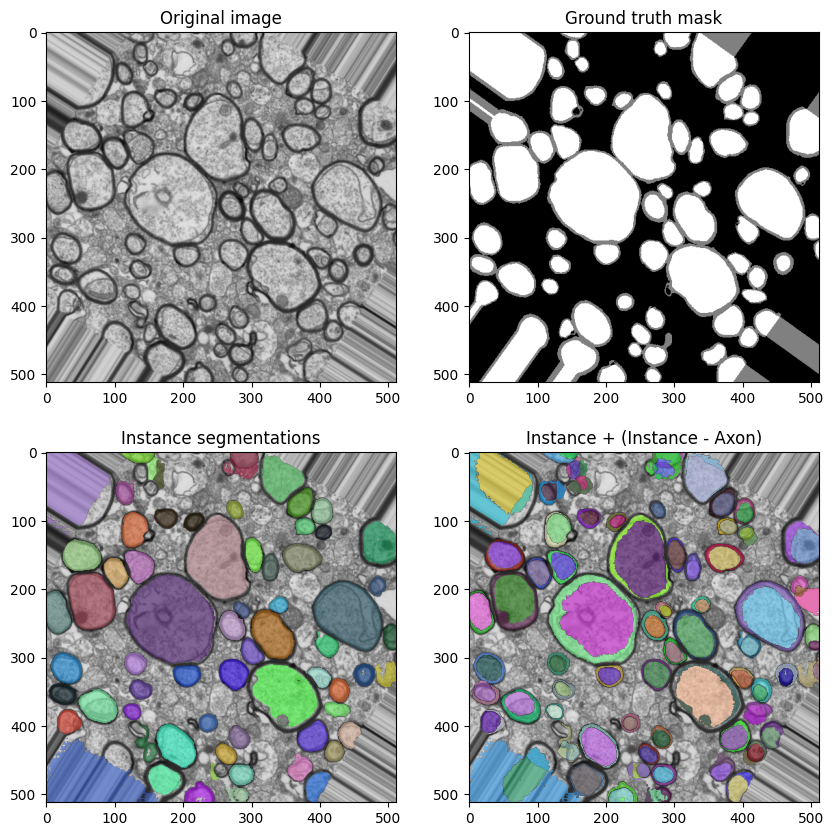

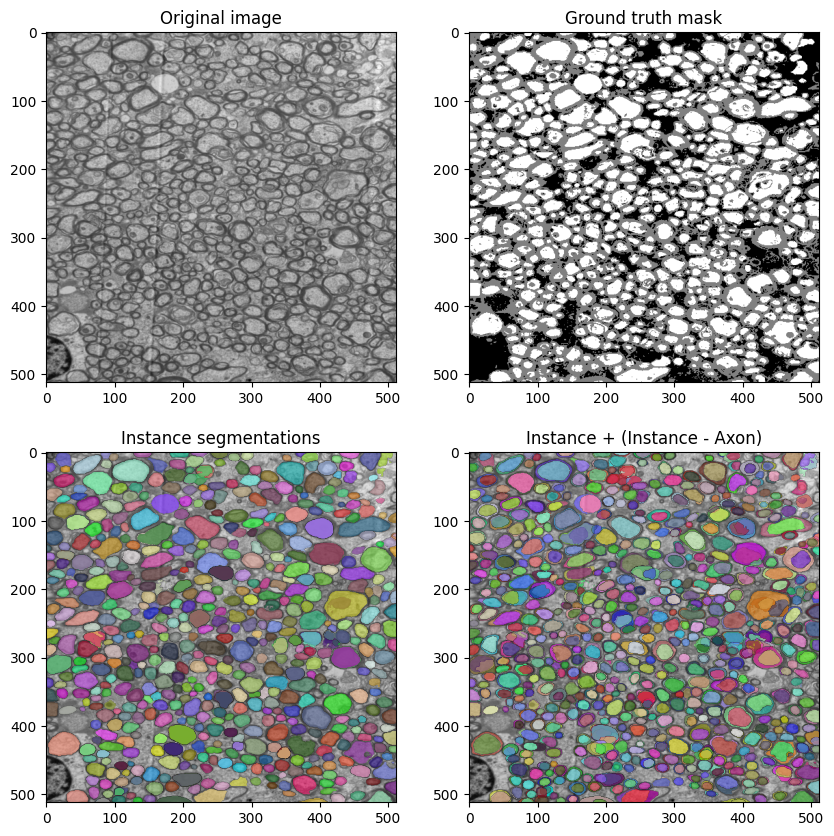

In [28]:
plot_image_result_diff("7_EM1_3_10D_N_P_0002_1.tif")
plot_image_result_diff("01_3.tif")

In [34]:
ious = []
ious_axon = []
ious_myelin = []
ious_at_large = []
for file_name, image in tqdm(read_dir(data_path.joinpath("val", "image_tif"))):
    gt_mask = tifffile.imread(str(data_path.joinpath("val", "mask_tif", file_name)))
    rgb_image = Image.fromarray(image).convert('RGB')
    axon_predictor.set_image(np.array(rgb_image))
    instance_predictor.set_image(np.array(rgb_image))
    axon_boxes, axon_centroids, myelin_points = get_boxes_points(gt_mask)

    axon_masks = np.zeros(gt_mask.shape)
    myelin_masks = np.zeros(gt_mask.shape)
    for index, point in enumerate(myelin_points + axon_centroids):
        axon_mask, _, _ = axon_predictor.predict(
            point_coords=np.array([point]),
            point_labels=np.array([1]),
            multimask_output=False
        )
        instance_mask, _, _ = instance_predictor.predict(
            point_coords=np.array([point]),
            point_labels=np.array([1]),
            multimask_output=False
        )
        myelin_masks += (axon_mask ^ instance_mask).squeeze(0)
        axon_masks += axon_mask.squeeze(0)
    axon_iou_score = compute_iou(torch.tensor(gt_mask == 2), torch.tensor(axon_masks > 0))
    myelin_iou_score = compute_iou(torch.tensor(gt_mask == 1), torch.tensor(myelin_masks > 0))
    ious.append(axon_iou_score)
    ious.append(myelin_iou_score)
    ious_axon.append(axon_iou_score)
    ious_myelin.append(myelin_iou_score)
    ious_at_large.append(compute_iou(torch.tensor((axon_masks + myelin_masks) > 0), torch.tensor(gt_mask > 0)))

print(
    f"The overall average IOU score over all classes of all images of the current model is {np.average(np.stack(ious))}"
)
print(
    f"The overall average IOU score over axon of all images of the current model is {np.average(np.stack(ious_axon))}"
)
print(
    f"The overall average IOU score over myelin of all images of the current model is {np.average(np.stack(ious_myelin))}"
)
print(
    f"The overall average IOU score at large of the current model is {np.average(np.stack(ious_at_large))}"
)

23it [08:20, 21.77s/it]

The overall average IOU score over all classes of all images of the current model is 0.3126710057258606
The overall average IOU score over axon of all images of the current model is 0.36756113171577454
The overall average IOU score over myelin of all images of the current model is 0.25778093934059143
The overall average IOU score at large of the current model is 0.6010389924049377
